# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['FISH', 'WOMAN', 'YESTERDAY', 'ANN', 'PREFER', 'HOMEWORK', 'CORN1', 'BOY', 'CANDY', 'CAR', 'POSS', 'DECIDE', 'SOMETHING-ONE', 'FINISH', 'LIVE', 'SHOOT', 'BLAME', 'LEG', 'IX-1P', 'PEOPLE', 'TEACHER', 'PARTY', 'ARRIVE', 'GIVE3', 'BILL', 'THROW', 'PAST', 'HAVE', 'LAST-WEEK', 'JOHN', 'BUY1', 'LEAVE', 'COAT', 'FUTURE1', 'APPLE', 'LOVE', 'GIVE', 'MOVIE', 'SAY', 'FRANK', 'WHAT', 'WONT', 'MARY', 'BUY', 'ALL', 'HIT', 'GIVE1', 'GET', 'SHOULD', 'CORN', 'POTATO', 'NEW', 'BOX', 'VIDEOTAPE', 'TOY', 'EAT', 'GO1', 'FRED', 'GO2', 'SELL', 'FRIEND', 'IX', 'NOT', 'READ', 'SUE', 'VEGETABLE', 'CHOCOLATE', 'BLUE', 'FIND', 'GO', 'CHICKEN', 'STOLEN', 'PUTASIDE', 'HERE', 'BORROW', 'TOMORROW', 'TOY1', 'LIKE', 'WHO', 'BUT', 'KNOW', 'HOUSE', 'STUDENT', 'NEW-YORK', 'THINK', 'GIRL', 'SAY-1P', 'SELF', 'SEE', 'BOOK', 'OLD', 'JANA', 'GIVE2', 'WRITE', 'WILL', 'WANT', 'GROUP', 'BROCCOLI', 'BREAK-DOWN', 'SEARCH-FOR', 'FUTURE', 'BROTHER', 'CHICAGO', 'MANY', 'MAN', 'MOTHER', 'NEXT-WEEK', 'VISIT', 'TELL', 'N

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
# ['grnd-rx','grnd-ry','grnd-lx','grnd-ly' for word chocolate]
training.get_word_Xlengths('CHOCOLATE') 

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit

# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()


# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing. 
    - Note for me: Refere to office hour vedio min-25 if you forgot what this is :)

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

def get_zScore(x, mean_,std_):  
    return (x-mean_)/std_



features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
locations = ['right-x', 'right-y', 'left-x', 'left-y']

for norm_, loc_ in zip(features_norm, locations):
    
    asl.df[norm_] = get_zScore(asl.df[loc_],asl.df['speaker'].map(df_means[loc_]),asl.df['speaker'].map(df_std[loc_]))

asl.df.head()


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly  
video frame                                
98    0      1.663433 -0.891199  0.741835  
      1      1.663433 -0.891199  0.741835  
      2      1.663433 -0.891199  0.741835  
      3      1.663433 -0.891199  0.741835  
      4      1.663433 -0.891199  0.741835

In [12]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle


'''
The "ground" right y value: grnd-ry feature is the difference between the right-hand y value and the nose y value
The reference is the nose
'''
#____________________________________________________________
import numpy as np

def get_rho(x, y):
    
    return np.sqrt(np.square(x) + np.square(y))
    
def get_theta(x, y):
    
    return np.arctan2(x, y)
#_____________________________________________________________
   

asl.df['polar-rr'] = get_rho(asl.df['grnd-rx'] , asl.df['grnd-ry'] )
asl.df['polar-rtheta'] = get_theta(asl.df['grnd-rx'] , asl.df['grnd-ry'] )

asl.df['polar-lr'] = get_rho(asl.df['grnd-lx'] , asl.df['grnd-ly'])
asl.df['polar-ltheta'] = get_theta(asl.df['grnd-lx'] , asl.df['grnd-ly'])


features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
     

In [13]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'


asl.df['delta-rx'] = asl.df['right-x']- asl.df['right-x'].shift(1)
asl.df['delta-ry'] = asl.df['right-y']- asl.df['right-y'].shift(1)
asl.df['delta-lx'] = asl.df['left-x'] - asl.df['left-x'].shift(1)
asl.df['delta-ly'] = asl.df['left-y'] - asl.df['left-y'].shift(1)

#accounting for the presence of nan in the first value.

asl.df['delta-rx'].values[0]= 0
asl.df['delta-ry'].values[0] = 0
asl.df['delta-lx'].values[0] = 0
asl.df['delta-ly'].values[0] = 0


features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']


In [14]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

#### (features_custom) The delta of the polar representation:

In [15]:
asl.df['delta-polar-rr'] = asl.df['polar-rr']- asl.df['polar-rr'].shift(1)
asl.df['delta-polar-lr'] = asl.df['polar-lr']- asl.df['polar-lr'].shift(1)
asl.df['delta-polar-rtheta'] = asl.df['polar-rtheta'] - asl.df['polar-rtheta'].shift(1)
asl.df['delta-polar-ltheta'] = asl.df['polar-ltheta'] - asl.df['polar-ltheta'].shift(1)

#accounting for the presence of nan in the first value.

asl.df['delta-polar-rr'].values[0]= 0
asl.df['delta-polar-lr'].values[0] = 0
asl.df['delta-polar-rtheta'].values[0] = 0
asl.df['delta-polar-ltheta'].values[0] = 0


features_custom = ['delta-polar-rr', 'delta-polar-lr', 'delta-polar-rtheta', 'delta-polar-ltheta']

#### (features_custom_1) The Modified Mahalanobis Distance:

In [16]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from scipy.spatial.distance import cosine


'''
The following function was adjusted from the following source:
http://kldavenport.com/mahalanobis-distance-and-outliers/

Main addition include:
    1) Calculating the Mutual Information between two inputs
    2) Calculating the COSINE Distance and Similarity
    3) Merging 1&2  to adjust the x & y points.
'''

def MahalanobisDist(x, y):
    covariance_xy = np.cov(x,y, rowvar=0)
    inv_covariance_xy = np.linalg.inv(covariance_xy)
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i - xy_mean[0] for x_i in x])
    y_diff = np.array([y_i - xy_mean[1] for y_i in y])
   
    cos_simil = 1- cosine(x,y) #1 - cosine(x,y)
    MI = adjusted_mutual_info_score(x, y)
    
    
    x_diff = (MI+cos_simil)* x_diff - np.abs(MI-cos_simil)* x_diff #- (y_diff - cos_simil)
    y_diff = (MI+cos_simil)* y_diff - np.abs(MI-cos_simil)* y_diff #(x_diff - cos_simil) 
    
    diff_xy = np.transpose([x_diff, y_diff])
    
    md = []
    for i in range(len(diff_xy)):
        md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
    return md


asl.df['A'] = MahalanobisDist(asl.df['delta-rx'],asl.df['right-x'])
asl.df['B'] = MahalanobisDist(asl.df['delta-ry'],asl.df['right-y'])

asl.df['C'] = MahalanobisDist(asl.df['delta-lx'],asl.df['left-x'])
asl.df['D'] = MahalanobisDist(asl.df['delta-ly'],asl.df['left-y'])

features_custom_1 =['A','B', 'C','D','delta-polar-rr', 'delta-polar-lr', 'delta-polar-rtheta', 'delta-polar-ltheta'  ]


----
**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

- ** (features_custom) The delta of the polar representation: **: Polar features was a good starting point that produced through various experimentations a low WER compared to normalization and delta, especially for CV. I expected it to produce a perfromance if difference in values was considered. This differencing property try to capture how much difference of the current reading is from its proceddeing. This method reduces the noise by waving out close by motions.


- ** (features_custom_1) The Modified Mahalanobis Distance: **: Motivated by the previous idea of reducing the noise of consecutive movements, I tried implementing a modified Mahlanobis Distance. In its essnse, the Mal-Distance will capture the number of standard deviations a given position is a way from the mean of the surrounding. I made use of the following heuristics before returning the final score:


     
    - The point is scaled by how much it is similar to other surrounding points in a deterministic sense (cosine distance) and probabilistic sense (Mutual Information). 
        
                 (MI+cos_simil)* x_diff - np.abs(MI-cos_simil)* x_diff
        
        If those two measure are similar, the second term will vanish and more weight will be given to the current feature. If they were different, the original score will be decreased because of the second term
  
The final feature set then combines the results obtained from features_custom_1 and the ones obtained by the difference in polar representation. More analysis will be presented when answering Question 3

----
<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [17]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.015s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [18]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433196


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [19]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance = np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
#for every state, we have 4 means and 4 var
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #1
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [20]:
my_testword = 'JOHN'#'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [ -21.021061     38.51024848    1.39270426  126.26889606]
variance =  [  52.50015648   98.66709622  168.30770438  300.17991637]

hidden state #1
mean =  [ -24.92747926   61.93716342   33.40672725  178.81045936]
variance =  [  80.27423577  400.10409204   82.68869582   16.54418295]

hidden state #2
mean =  [ -11.7408851    77.82681668    4.81285139  134.10189748]
variance =  [  86.14500669  328.74048785  313.66048313  140.88634919]

logL = -18266.910547407097


------

In [21]:
def predict_Features(feature_name, num_states = 3):
    my_testword = 'JOHN'#'CHOCOLATE'
    model, logL = train_a_word(my_testword, num_states, feature_name) # Experiment here with different parameters
    show_model_stats(my_testword, model)
    print("logL = {}".format(logL))

### 1. Normal Features 

In [22]:
predict_Features(features_norm) 

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [ 0.07528669 -0.11156619 -0.2954424   0.703788  ]
variance =  [ 0.26110728  0.42563437  0.35497171  0.05987981]

hidden state #1
mean =  [-0.49410182 -0.60838726 -0.00531761  0.53510904]
variance =  [ 0.07279973  0.07380867  0.08898768  0.00514101]

hidden state #2
mean =  [-0.63832309 -0.57010248  0.80687646 -0.2902217 ]
variance =  [ 0.3125953   0.03568898  1.95090529  0.61466656]

logL = -1846.7988518722534


### 2. Polar Features 

In [23]:
predict_Features(features_polar) 

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [  4.45952797e+01  -5.13725825e-01   1.27193774e+02   1.75771579e-02]
variance =  [  8.83814119e+01   3.39117898e-02   2.90815054e+02   1.34783291e-02]

hidden state #1
mean =  [  67.62334817   -0.39949253  182.07995164    0.18471604]
variance =  [  3.55789337e+02   2.87143970e-02   2.19887793e+01   2.37763963e-03]

hidden state #2
mean =  [  7.92613779e+01  -1.56995363e-01   1.34868842e+02   2.67663971e-02]
variance =  [  3.16745345e+02   1.49476965e-02   1.20134365e+02   1.77787436e-02]

logL = -7636.837492407981


### 3. Delta Features 

In [24]:
 predict_Features(features_delta)  

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [-1.54687356 -4.26561816 -0.02343744 -0.16406205]
variance =  [  7.30252625  31.59350055   9.39008894  19.7308809 ]

hidden state #1
mean =  [-1.41201746 -5.28326445  0.          0.        ]
variance =  [  6.59634740e+00   3.54433891e+01   1.07296218e-05   1.07296218e-05]

hidden state #2
mean =  [  -8. -132.   -1.   -1.]
variance =  [ 0.01  0.01  0.01  0.01]

logL = 589.7153180756551


### 4. Custom Features

In [25]:
predict_Features(features_custom,3)

Number of states trained in model for JOHN is 3
hidden state #0
mean =  [ -4.96478666e+00  -1.97370759e-05  -3.74828831e-02  -3.19214117e-05]
variance =  [  3.28609536e+01   1.17525438e-05   2.60986327e-03   1.18860995e-05]

hidden state #1
mean =  [ -1.25087442e+02   3.55574801e+00  -2.73008703e-01   1.91570205e-02]
variance =  [ 0.01  0.01  0.01  0.01]

hidden state #2
mean =  [ -3.66308888e+00  -2.38776799e-01  -3.73352141e-02   4.14566211e-04]
variance =  [  2.82055957e+01   1.57640304e+01   3.74688638e-03   5.03445035e-04]

logL = 5567.681673382761


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [26]:
%matplotlib inline

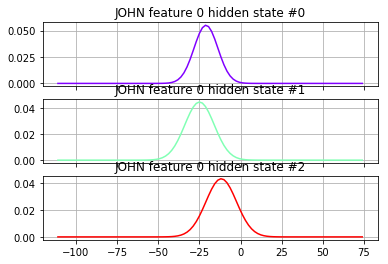

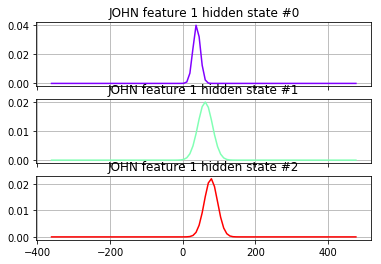

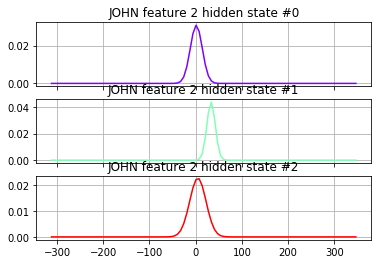

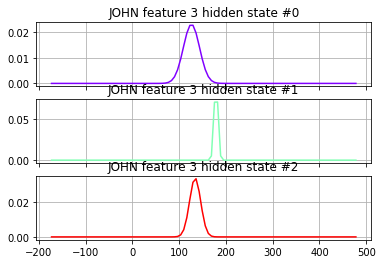

In [27]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [28]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [29]:
from sklearn.model_selection import KFold     

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [30]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [31]:
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
from my_model_selectors import SelectorCV

In [32]:
#-----------------Suggested to add these in the forum ---------------------------------------
# https://discussions.udacity.com/t/nonetype-object-has-no-attribute-n-components/247439/12
#--------------------------------------------------------------------------------------------
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
#============================================================================================

# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.015068048347637203 seconds
Training complete for BOOK with 12 states with time 5.313045259195811 seconds
Training complete for VEGETABLE with 15 states with time 1.7836752079332818 seconds
Training complete for FUTURE with 15 states with time 5.6098547406175765 seconds
Training complete for JOHN with 15 states with time 52.48153559918562 seconds


In [33]:
#-----------------Suggested to add these in the forum ---------------------------------------
# https://discussions.udacity.com/t/nonetype-object-has-no-attribute-n-components/247439/12
#--------------------------------------------------------------------------------------------
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
#============================================================================================

# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.31185560276858837 seconds
Training complete for BOOK with 8 states with time 1.8386793227449232 seconds
Training complete for VEGETABLE with 9 states with time 0.6255638038401088 seconds
Training complete for FUTURE with 9 states with time 1.9117657487184374 seconds
Training complete for JOHN with 13 states with time 18.305693649007495 seconds


In [34]:
#-----------------Suggested to add these in the forum ---------------------------------------
# https://discussions.udacity.com/t/nonetype-object-has-no-attribute-n-components/247439/12
#--------------------------------------------------------------------------------------------
from importlib import reload
import my_model_selectors
reload(my_model_selectors)
#============================================================================================


# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.7746524803636703 seconds
Training complete for BOOK with 15 states with time 3.6000883611479537 seconds
Training complete for VEGETABLE with 15 states with time 2.6357038753874633 seconds
Training complete for FUTURE with 15 states with time 3.695542194081014 seconds
Training complete for JOHN with 15 states with time 19.51590454010214 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**







** BACKGROUND **

* Model selection provides a tool for configuring HMM parameters. Choosing an HMM topology is very crucial for achieving a high-performing system and directly affects the modeling and includes deciding on the 

    - number of states, 
    - the number of mixtures per state
    - the transition between states, 

  

* Rather than heuristically choosing a **constant** HMM topology, three alternative methods were implemented in corrosponding derived classes of **ModelSelector** in order to compare their performance. These classes are:

    1. SelectorCV(ModelSelector): includes select method that implements Corss validation 
    2. SelectorBIC(ModelSelector): includes select method that implements Bayesian Information Criterion
    3. SelectorDIC(ModelSelector): includes select method that implements Discriminative Information Criterion


** COMPARISON **

- **Corss validation** tries to tune the log-likelihood of a given occurence and chooses the best estimate by training. It tires to avoid overfitting by scrambling input data and preserving some portion for validation purposes. Generally speaking, the likelihood criterion is a poor choice for model selection as the complexity increases incrementally with the number of parameters.


- **BIC** penalizes large-size models and focuses on estimating models using within-class statistics, without regard to competing classification categories. When it comes to utilizing Bayesian techniques to HMM, there is no guarantee that the resulting model are optimal in regard to error minimization.


- **DIC**, on the other hand, penalizes the similarity among different words enabling choosing the model that is most likely to be distinctive. For achieving that DIC introduces an anti-evidence term that measures capacity of the corresponding model to generate data belonging to competing classes. By choosing the model which maximizes the evidence, and minimize the antievidences, the result is the best generative model for the correct class and the worst generative model for the competitive classes 




---
** Main Ref. **
_"A model selection criterion for classification: Application to hmm topology optimization." Document Analysis and Recognition, 2003. Proceedings. Seventh International Conference on. IEEE, 2003._

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [35]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 61.452s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [36]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [37]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [38]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

import warnings
warnings.filterwarnings('ignore')

### Option 1: 

- **Feature Set**           : features_custom
- ** Parameter Selection**  : SelectorCV

In [39]:
%%time

#features_custom,features_custom, features_delta, features_polar, features_norm
# SelectorBIC ,SelectorDIC, SelectorCV

features = features_custom              #features_ground # change as needed
model_selector = SelectorCV             #   SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)

show_errors(guesses, test_set)


**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
  100: *IX NEW CAR *HOUSE                                            POSS NEW CAR BREAK-DOWN
    2: *IX *IX HOMEWORK                                              JOHN WRITE HOMEWORK
   67: JOHN *IX *IX *GIVE3 HOUSE                                     JOHN FUTURE NOT BUY HOUSE
    7: JOHN *FRIEND GO *GIVE3                                        JOHN CAN GO CAN
  201: JOHN *NOT *WHO *JOHN BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *IX *WHO *IX                                             JOHN NOT VISIT MARY
  119: *JOHN *BUY1 IX CAR *IX                                        SUE BUY IX CAR BLUE
   12: JOHN CAN *BROTHER CAN                                         JOHN CAN GO CAN
   77: *JOHN BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT *MARY                  

### Option 2: 

- **Feature Set**           : features_polar
- ** Parameter Selection**  : SelectorCV

In [40]:
%%time


features = features_polar              #features_ground # change as needed
model_selector = SelectorCV          #   SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)

show_errors(guesses, test_set)


**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
  201: JOHN *MAN *LOVE *JOHN BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *GO *GO *VISIT                                            JOHN NOT VISIT MARY
  119: *MARY *BUY1 IX *BLAME *IX                                     SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   77: *JOHN *GIVE1 MARY                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

### Option 3: 

- **Feature Set**           : features_delta
- ** Parameter Selection**  : SelectorDIC

In [41]:
%%time


import warnings
warnings.filterwarnings('ignore')

features = features_norm              #features_ground # change as needed
model_selector = SelectorDIC          #   SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)

show_errors(guesses, test_set)


**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
   67: *MARY *IX *JOHN *ARRIVE HOUSE                                 JOHN FUTURE NOT BUY HOUSE
    7: *MARY *CAR GO CAN                                             JOHN CAN GO CAN
  201: JOHN *GIVE1 *IX *WOMAN *ARRIVE HOUSE                          JOHN TELL MARY IX-1P BUY HOUSE
   74: *GO *VISIT VISIT MARY                                         JOHN NOT VISIT MARY
  119: SUE *BUY1 IX *JOHN *GO                                        SUE BUY IX CAR BLUE
   12: JOHN *WHAT *ARRIVE CAN                                        JOHN CAN GO CAN
   77: ANN BLAME MARY                                                ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

### Option 4: 

- **Feature Set**           : features_custom_1
- ** Parameter Selection**  : SelectorBIC

In [42]:
%%time

#features_custom,features_custom, features_delta, features_polar, features_norm
# SelectorBIC ,SelectorDIC, SelectorCV



features = features_custom_1              #features_ground # change as needed
model_selector = SelectorBIC          #   SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)

show_errors(guesses, test_set)


**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *MARY *HOUSE                                             JOHN WRITE HOMEWORK
   67: JOHN FUTURE *APPLE BUY HOUSE                                  JOHN FUTURE NOT BUY HOUSE
    7: JOHN *HAVE GO *STUDENT                                        JOHN CAN GO CAN
  201: JOHN *MARY MARY *JOHN BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: JOHN *JOHN *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *JOHN *BUY1 *WHAT CAR *JOHN                                   SUE BUY IX CAR BLUE
   12: JOHN CAN *ARRIVE CAN                                          JOHN CAN GO CAN
   77: *JOHN *VISIT MARY                                             ANN BLAME MARY
  142: JOHN BUY *FUTURE WHAT *NEW-YORK                

## DISCUSSION

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

I ran exhaustive experiments for all the proposed features and the selection methods. As expected, select method in SelectorCV class took a very long time as every proposed sequence is split, combined and evaluated before finally computing the average value of LogL.  This contrasts with select methods in SelectorBIC where we only examine the provided range of possible n_components range. In addition to calculating the logL in both DIC and BIC, DIC takes extra time, depending on the implementation, when calculating the anti-evidence part.
For these experiments, the lowest WER was recorded for polar features and the second lowest for custom features that considers the difference in polar values. Both feature sets utilized the select method in SelectorCV. 
I tried to build another custom feature centered around capturing similarity among the provided features by calculating the Mahalanobi Distance and weighting the values by other similarity metrics: the Mutual Information (MI) and COSIN distance (CD). The motive behind my thinking was as follows:
-	I needed to account for various shared information with other features in a statistical sense, that is why I considered (MI)
-	I needed to capture how the points are physically separated. (CD)
-	I wanted to combine the previous two items, and in the same time capturing how statistically the points were separated. That is why I combined them in the way described earlier in calculating the Mahalanobi distance.
What I wanted to do was to cluster similar movements captured by certain features and then come up with clear classification borders. I was able to produce low WER in the beginning but I failed to reproduce it at a later stage. :)

The following summarizes the finding and lists some top combinations   

| Feature Set   | select method in   | WER         | Time | 
|:-------------:|:-------------:|:-------------------:|:--------:|
| features_polar | SelectorCV      | 0.528     | 2min 35s|
| features_custom    | SelectorCV    | 0.573 | 3min 36s |
| features_norm   | SelectorDIC   | 0.595 | 3min 13 s|
| features_custom_1   | SelectorBIC      | 0.584    |1min 25s|


#### Conclusion
This is a very interesting field where various ideas maybe tried to come up with better combinations. As suggested in the optional part, embedding some statistical information on group of words might result in better results. Other ideas include accounting for word frequencies, various similarity measures and using deep neural networks for training. I might consider exploring such options if I went to this specialization in the second term.


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [43]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 29.673s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

-------
<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [44]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,82.670341,-inf,55.873472,78.056198,37.639792,14.165736,-787.182261,22.138702,29.668686,53.793808,...,23.943818,110.571743,-69.711202,55.237465,105.906614,61.684245,133.859420,54.782999,42.287950,53.781664
1,39.098083,-inf,51.398469,102.014123,-29.288279,43.744157,-716.391499,114.421558,29.872693,63.373150,...,88.064517,114.066630,-3.071063,94.782869,94.438549,-285.863640,67.494597,81.832569,125.328294,41.627908
2,59.365978,-inf,128.334699,183.514499,-8.553639,83.504233,-880.398357,191.661226,-98.116160,145.243970,...,186.235302,206.652505,-60.667861,145.385261,195.450831,-687.430664,113.044105,183.320408,120.671912,145.466891
3,152.470029,-inf,132.431174,129.889467,170.803317,-27.169656,-408.870323,115.152826,2.856502,77.511173,...,68.672876,156.783319,-141.085141,184.672524,190.724470,-84.062663,209.314955,141.582668,119.748678,119.632783
4,-54.410524,-inf,-223.611610,23.308252,-301.478954,21.707176,-783.574866,22.871686,-19.850745,12.748136,...,-35.988824,33.581193,-46.858685,-13.031603,-25.278288,-262.170572,-92.523126,-74.239058,-20.065508,-159.968099
